In [1]:
# Importing libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

In [2]:
# Creating a 10 stock portfolio 
Portfolio = ['AAPL', 'BRK-B', 'GS', 'NVDA', 'IBM', 'AMD', 'INTC', 'NKE', 'GS', 'META']

# Loading in financial data
Data = yf.download(Portfolio, period='10y')['Adj Close']

[*********************100%%**********************]  9 of 9 completed


In [3]:
# Creating a DataFrame for the first table
Table_1 = pd.DataFrame(index=Portfolio)

# Calculating equal weight
Table_1['Weight'] = 100 / len(Portfolio)

# Calculate returns for stocks
Returns = Data.pct_change().dropna()

# Calculating annual volatility for each stock (using trailing 3 months)
Table_1['Annual Volatility'] = Returns[-63:].std() * np.sqrt(252)

# Calculate Beta against SPY, IWM, and DIA (using trailing 12 months)
for etf in ['SPY', 'IWM', 'DIA']:
    # Download adjusted close prices for the ETF
    ETF_Data = yf.download(etf, period='10y')['Adj Close']
    
    # Calculate returns for the ETF
    ETF_Returns = ETF_Data.pct_change().dropna()
    
    # Ensure the lengths of Returns and ETF_Returns match
    ETF_Returns = ETF_Returns[-len(Returns):]
    Returns = Returns[-len(ETF_Returns):]
    
    # Merge stock and ETF returns into a single DataFrame
    Combined_Data = pd.concat([Returns, ETF_Returns.rename(etf)], axis=1).dropna()
    
    # Calculate rolling covariance between each stock and the ETF returns
    Rolling_Cov = Combined_Data.rolling(window=len(ETF_Returns)).cov()
    
    # Calculate rolling variance of the ETF returns
    Rolling_Var = Combined_Data[etf].rolling(window=len(ETF_Returns)).var()
    
    # Calculate beta by dividing rolling covariance by ETF variance
    Betas = Rolling_Cov.xs(etf, level=1, axis=0).div(Rolling_Var, axis=0)
    
    # Store beta values in the Table_1 DataFrame
    Table_1[f'Beta against {etf}'] = Betas.iloc[-1]
    
# weekly average drawdown
Table_1['Average Drawdown'] = ((Data.rolling(5).min() - Data.rolling(5).max()) / Data.rolling(5).max()).mean()

# weekly maximum drawdown
Table_1['Maximum Drawdown'] =  ((Data.rolling(5).min() -  Data.rolling(5).max()) / Data.rolling(5).max()).max()

# Total return of ETF
Table_1['Total Return'] = total_return = (Data.iloc[-1] / Data.iloc[0] - 1) * 100

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# Looking at the first table
Table_1

,Weight,Annual Volatility,Beta against SPY,Beta against IWM,Beta against DIA,Average Drawdown,Maximum Drawdown,Total Return
AAPL,10.0,0.280094,1.215083,0.747617,1.105718,-0.034324,-0.002498,893.256019
BRK-B,10.0,0.126174,0.877089,0.605738,0.932136,-0.022502,-0.001939,237.532153
GS,10.0,0.194240,1.188127,0.931279,1.284995,-0.034231,-0.002721,238.939099
NVDA,10.0,0.532289,1.722634,1.136088,1.427132,-0.056128,-0.004938,26525.032236
IBM,10.0,0.239164,0.847129,0.600896,0.925983,-0.027330,-0.002044,57.269934
AMD,10.0,0.468643,1.649730,1.167211,1.386837,-0.068007,-0.005263,3608.311169
INTC,10.0,0.356677,1.222817,0.827087,1.159619,-0.038586,-0.001728,19.233879
NKE,10.0,0.453347,1.043523,0.738680,1.042001,-0.033987,-0.001510,103.622537
GS,10.0,0.194240,1.188127,0.931279,1.284995,-0.034231,-0.002721,238.939099
META,10.0,0.379920,1.287576,0.801891,1.056569,-0.041408,-0.002608,506.435861


In [5]:
# List of ETF symbols to analyze
ETF = ['SPY', 'IWM', 'DIA']

# Combine ETF and stock tickers
all_tickers = ETF + Portfolio

# Fetch data for the ETFs and stocks from Yahoo Finance (10 years of data)
all_data = yf.download(all_tickers, period='10y')

# Use adjusted close prices for calculations
closing_prices = all_data["Adj Close"]

# Calculate daily returns for all assets (ETFs and stocks)
returns = closing_prices.pct_change().dropna()

# Calculate the portfolio returns (equal-weighted)
portfolio_returns = returns[Portfolio].mean(axis=1)

# Convert risk-free rate to a decimal 
risk_free_rate = 4.59 / 100

# DataFrame to store portfolio risk metrics against the ETFs
portfolio_metrics = pd.DataFrame(index=ETF)

# Loop through each ETF to calculate various metrics
for etf in ETF:
    # Returns for the specific ETF
    etf_returns = returns[etf]
    
    # Correlation with portfolio
    portfolio_metrics.loc[etf, 'Correlation'] = portfolio_returns.corr(etf_returns)
    
    # Covariance with portfolio
    portfolio_metrics.loc[etf, 'Covariance'] = portfolio_returns.cov(etf_returns)
    
    # Tracking error (standard deviation of difference in returns)
    portfolio_metrics.loc[etf, 'Tracking Error'] = np.sqrt(((portfolio_returns - etf_returns) ** 2).mean())
    
    # Annualized volatility for the ETF and portfolio
    etf_volatility = etf_returns.std() * np.sqrt(252)
    portfolio_volatility = portfolio_returns.std() * np.sqrt(252)
    
    # Sharpe Ratio for the ETF
    etf_annual_return = etf_returns.mean() * 252
    portfolio_metrics.loc[etf, 'Sharpe Ratio'] = (etf_annual_return - risk_free_rate) / etf_volatility
    
    # Annualized Volatility Spread (Portfolio Volatility - ETF Volatility)
    portfolio_metrics.loc[etf, 'Volatility Spread'] = portfolio_volatility - etf_volatility

# Round the values for better readability
portfolio_metrics = portfolio_metrics.round(4)

# Add portfolio returns to the returns DataFrame
returns['Portfolio'] = portfolio_returns

# Calculate the correlation matrix for the portfolio, ETFs, and stocks
all_assets = ['Portfolio'] + ETF + Portfolio
full_correlation_matrix = returns[all_assets].corr()

[*********************100%%**********************]  12 of 12 completed


In [6]:
# Display the portfolio risk metrics DataFrame (Table 2)
portfolio_metrics

,Correlation,Covariance,Tracking Error,Sharpe Ratio,Volatility Spread
SPY,0.9151,0.0001,0.0065,0.4999,0.0593
IWM,0.8050,0.0002,0.0090,0.2666,0.0121
DIA,0.8607,0.0001,0.0078,0.4380,0.0607


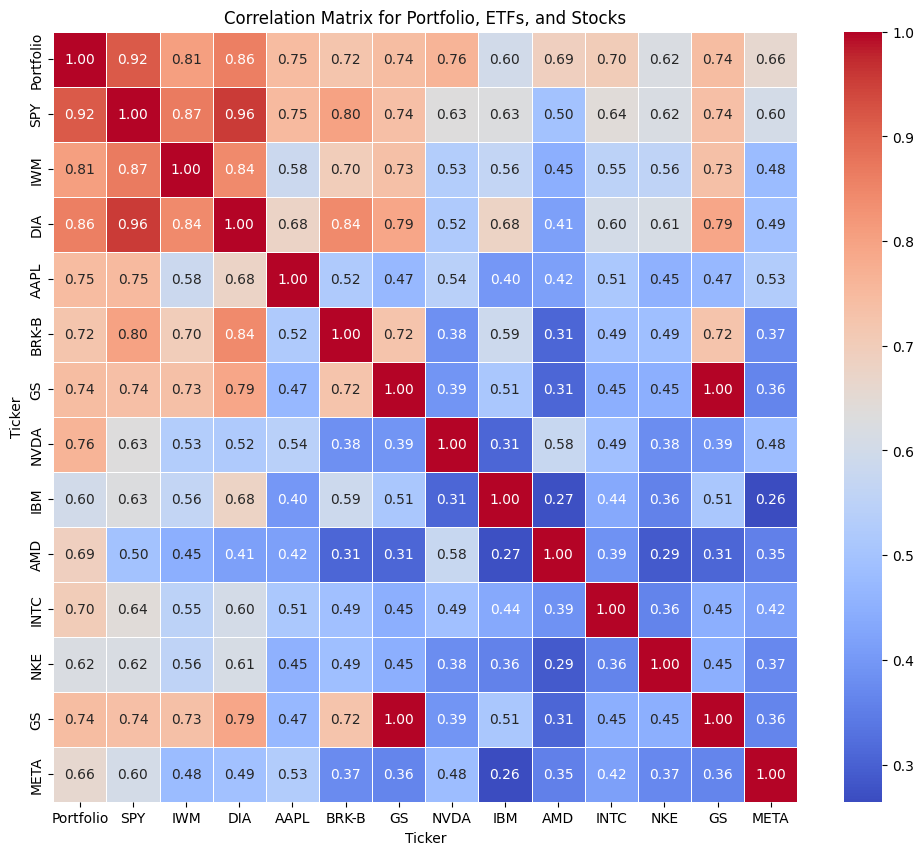

In [7]:
# Plot the correlation matrix using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(full_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=.5)
plt.title("Correlation Matrix for Portfolio, ETFs, and Stocks")
plt.show()

In [8]:
# Creating function to collect tickers of ETF
def identifying_assets():
    # Define the URL of the webpage containing the list of S&P 500 companies
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    
    # Read the HTML content of the webpage and store it in the 'data' variable
    data = pd.read_html(url)
    
    # Extract the first table from the HTML content that contains the company data
    table = data[0]
    
    # Extract the ticker symbols of the first 500 companies from the table and convert them to a list
    ticks = table.head(500)['Symbol'].tolist()
    
    # Return the list of ticker symbols
    return ticks

In [9]:
# List of ETF tickers for 'IWM' and 'DIA'
etfs = ['IWM', 'DIA']

# Call the function 'identifying_assets' to get the S&P 500 tickers
spy_tickers = identifying_assets()

# Download adjusted close price data for S&P 500 tickers for the last 10 years
Data = yf.download(spy_tickers, period='10y')['Adj Close']

# Download adjusted close price data for 'IWM' and 'DIA' ETFs for the last 10 years
data_etfs = yf.download(etfs, period='10y')['Adj Close']

# Download volume data for S&P 500 tickers for the last 5 years
Volume_Data = yf.download(spy_tickers, period='5y')['Volume']

# Clean the data by removing specific columns from 'Data'
Data = Data.drop(columns=['BF.B', 'BRK.B', 'AXON', 'ABNB'], errors='ignore')

# Drop columns with missing values in 'Volume_Data'
Volume_Data = Volume_Data.dropna(axis=1)

# Calculate daily returns from 'Data' and drop rows with missing values
returns = Data.pct_change().dropna()

# Extract annual returns by selecting the last 252 trading days
ann_returns = returns[-252:]

# Convert the index of returns to datetime format for better readability
returns.index = pd.to_datetime(returns.index)


[**********************94%%*******************   ]  469 of 500 completed

$BF.B: possibly delisted; No price data found  (period=10y)


[*********************100%%**********************]  500 of 500 completed

12 Failed downloads:
['GEV', 'SOLV']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']")
['VLTO']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']")
['KVUE', 'GEHC']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']")
['CARR', 'OTIS', 'ABNB', 'CEG']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', 'ytd', 'max']")
['BRK.B']: YFChartError('%ticker%: No data found, symbol may be delisted')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (period=10y)')
['SW']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', 'ytd', 'max']")
[*************

$BF.B: possibly delisted; No price data found  (period=5y)


[*********************100%%**********************]  500 of 500 completed

8 Failed downloads:
['GEV', 'SOLV']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']")
['VLTO']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']")
['KVUE', 'GEHC']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']")
['BRK.B']: YFChartError('%ticker%: No data found, symbol may be delisted')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (period=5y)')
['SW']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', 'ytd', 'max']")
C:\Users\Mnzmt\AppData\Local\Temp\ipykernel_2912\3829414939.py:23: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Ei

In [10]:
class EF_MC:
    def __init__(self, stocks):
        
        # Store the list of stocks provided during initialization
        self.stocks = stocks
        
        # Initialize the mean returns as None
        self.mean_returns = None
        
        # Initialize the covariance matrix as None
        self.covariance_matrix = None
        
        # Initialize the correlation matrix as None
        self.correlation_matrix = None
        
        # Initialize the results array as None
        self.results = None
        
        # Initialize the optimal weights as None
        self.optimal_weights = None

    def phase_1(self):
        
        # Drop columns with missing values in the data
        Data.dropna(axis=1, inplace=True)
        
        # Update the list of stocks with the cleaned data columns
        self.stocks = Data.columns.tolist()
        
        # Calculate daily returns and drop rows with missing values
        returns = Data.pct_change().dropna()
        
        # Calculate and store the mean returns for each stock
        self.mean_returns = returns.mean()
        
        # Calculate and store the covariance matrix of returns
        self.covariance_matrix = returns.cov()
        
        # Calculate and store the correlation matrix of returns
        self.correlation_matrix = returns.corr()

    def phase_2(self, num_portfolios=10000):
        
        # Determine the number of stocks in the portfolio
        num_stocks = len(self.stocks)
        
        # Initialize an array to store results of portfolios
        results = np.zeros((3 + num_stocks, num_portfolios))
        
        # Set the risk-free rate used in Sharpe ratio calculation
        risk_free_rate = 0.0486
    
        # Loop over the number of portfolios to simulate
        for i in range(num_portfolios):
            
            # Generate random weights for stocks
            weights = np.random.dirichlet(np.ones(num_stocks), size=1).flatten()
            
            # Calculate annualized portfolio return
            portfolio_return = np.sum(weights * self.mean_returns) * 252
            
            # Calculate annualized portfolio standard deviation (risk)
            portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix * 252, weights)))
            
            # Store the calculated portfolio return
            results[0, i] = portfolio_return
            
            # Store the calculated portfolio risk
            results[1, i] = portfolio_std_dev
            
            # Calculate and store the Sharpe ratio
            results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
            
            # Store the portfolio weights
            results[3:, i] = weights

        # Store the results array in the class instance
        self.results = results
        
        # Find the index of the portfolio with the maximum Sharpe ratio
        max_sharpe_idx = np.argmax(results[2])
        
        # Store the weights of the optimal portfolio
        self.optimal_weights = results[3:, max_sharpe_idx]

    def plot_efficient_frontier(self):
        
        # Set the figure size for the plot
        plt.figure(figsize=(10, 5))
        
        # Create a scatter plot of risk vs. return, colored by Sharpe ratio
        plt.scatter(self.results[1, :], self.results[0, :], c=self.results[2, :], cmap='YlGnBu', marker='o')
        
        # Set the title of the plot
        plt.title('Efficient Frontier')
        
        # Label the x-axis as risk (standard deviation)
        plt.xlabel('Risk Standard Deviation')
        
        # Label the y-axis as return
        plt.ylabel('Return')
        
        # Add a color bar to represent the Sharpe ratio
        plt.colorbar(label='Sharpe Ratio')
        
        # Display the plot
        plt.show()


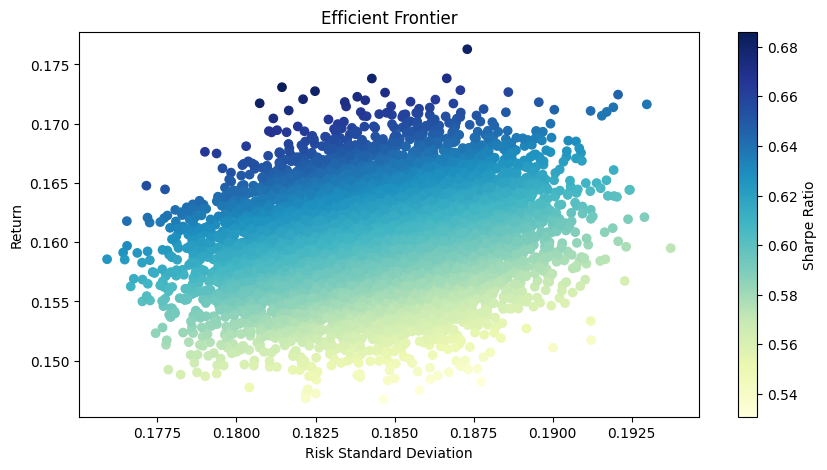

In [11]:
# Instantiate the class with the initial list of tickers
ef_mc = EF_MC(spy_tickers)

# Download data and compute statistics
ef_mc.phase_1()

# Now you can continue with the rest of the analysis
ef_mc.phase_2(num_portfolios=10000)
ef_mc.plot_efficient_frontier()

In [12]:
# Class for calculating price momentum factors
class PriceMomentumCalculator:
    def __init__(self, data):
        
        # Initialize with the last 260 days of data
        self.data = data.tail(280).head(260)

    def slope_52_week(self):
        
        # Calculate the slope of the linear regression over 52 weeks
        return self.data.apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])

    def percent_above_260day_low(self):
        
        # Get minimum prices (260-day low)
        min_prices = self.data.min()
        
        # Get the last price
        last_prices = self.data.iloc[-1]
        
        # Calculate the percentage above the 260-day low for each asset
        return (last_prices - min_prices) / min_prices * 100

    def price_oscillator(self):
        
        # Mean of the last 20 days
        mean_20 = self.data.tail(20).mean()
        
        # Overall mean price
        overall_mean = self.data.mean()
        
        # Calculate the price oscillator (20-day average vs overall average)
        return (mean_20 - overall_mean) / overall_mean * 100

# Function for calculating 39-week return
def _39week_return(data):
    
    # Data for the last 39 weeks
    recent_data = data.tail(299).head(195)
    
    # Calculate the percentage return over the 39-week period
    return (recent_data.iloc[-1] - recent_data.iloc[0]) / recent_data.iloc[0] * 100

# Class for asset selection based on calculated factors
class AssetSelection:
    
    def __init__(self, data, pm_calculator, volume_data):
        # Initialize with price data, momentum calculator, and volume data
        self.data = data
        self.pm_calculator = pm_calculator
        self.volume_data = volume_data

    def volume_price_trend(self):
        
        # Price data for calculation
        price_data = self.data.tail(272).head(255)
        
        # Volume data for calculation
        vol_data = self.volume_data.tail(272).head(255)
        
        # Cumulative trend
        return ((price_data.diff() * vol_data).cumsum()).iloc[-1]

    def select_assets(self):
        
        # Calculate various scores based on momentum factors
        scores = pd.DataFrame({
            'slope_52_week': self.pm_calculator.slope_52_week(),
            'percent_above_260day_low': self.pm_calculator.percent_above_260day_low(),
            'price_oscillator': self.pm_calculator.price_oscillator(),
            'week_39_return': _39week_return(self.data),
            'volume_price_trend': self.volume_price_trend()
        })

        # Mean score for each asset
        combined_scores = scores.mean(axis=1)
        
        # Sort by score
        sorted_scores = combined_scores.sort_values(ascending=False)
        
        # Top 15 assets
        long_basket = sorted_scores.head(15).index.tolist()
        
        # Bottom 15 assets
        short_basket = sorted_scores.tail(15).index.tolist()
        
        # Return selected assets
        return long_basket, short_basket

# Class for backtesting the portfolio
class Backtest:
    
    def __init__(self, data, volume_data, asset_selector):
        
        # Initialize with data, volume data, and asset selector
        self.data = data
        self.volume_data = volume_data
        self.asset_selector = asset_selector

    def calculate_monthly_returns(self, start_date, end_date):
        
        # Get selected assets
        long_basket, short_basket = self.asset_selector.select_assets()
        
        # Filter out assets not present in data
        long_basket = [asset for asset in long_basket if asset in self.data.columns]
        short_basket = [asset for asset in short_basket if asset in self.data.columns]
        
        # Data for the specific month
        monthly_data = self.data.loc[start_date:end_date]
        
        # Calculate returns
        monthly_returns_data = monthly_data.pct_change().dropna()
        
        # Determine weights for long and short positions
        long_weight = 1 / len(long_basket) if long_basket else 0
        short_weight = -1 / len(short_basket) if short_basket else 0
        
        # Initialize returns
        long_return = short_return = etf_return = 0
        
        # Check if data is not empty
        if not monthly_returns_data.empty:
            
            # Calculate long position returns
            if long_basket:
                long_return = (monthly_returns_data[long_basket] * long_weight).sum(axis=1).iloc[-1]
            
            # Calculate short position returns
            if short_basket:
                short_return = (monthly_returns_data[short_basket] * short_weight).sum(axis=1).iloc[-1]
           
            # Total return for the month
            total_return = long_return + short_return
            
            # ETF return
            etf_return = monthly_data.mean(axis=1).pct_change().dropna().iloc[-1]
            
            # Return all values
            return total_return, long_return, short_return, etf_return
       
        # Return zeros if data is empty
        return 0, 0, 0, 0

    def backtest_portfolio(self):
        
        # Backtest the portfolio over all months in the data
        results = []
        
        # Iterate over each month end date
        for month_end in pd.date_range(start=self.data.index.min(), end=self.data.index.max(), freq='M'):
            
            # Start of the month
            month_start = month_end - pd.offsets.MonthBegin(1)
           
            # Calculate monthly returns
            total_return, long_return, short_return, etf_return = self.calculate_monthly_returns(month_start, month_end)
           
            # Append results
            results.append({
                'date': month_end,
                'total_return': total_return,
                'long_return': long_return,
                'short_return': short_return,
                'etf_return': etf_return
            })
       
        # Return backtest results as a DataFrame
        return pd.DataFrame(results)

# Initialize the momentum calculator with the price data
pm_calculator = PriceMomentumCalculator(Data)

# Initialize the asset selector with price data, momentum calculator, and volume data
asset_selector = AssetSelection(Data, pm_calculator, Volume_Data)

# Initialize the backtest with price data, volume data, and asset selector
backtest = Backtest(Data, Volume_Data, asset_selector)

# Perform backtesting and get results
backtest_results = backtest.backtest_portfolio()

C:\Users\Mnzmt\AppData\Local\Temp\ipykernel_2912\188290100.py:151: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month_end in pd.date_range(start=self.data.index.min(), end=self.data.index.max(), freq='M'):


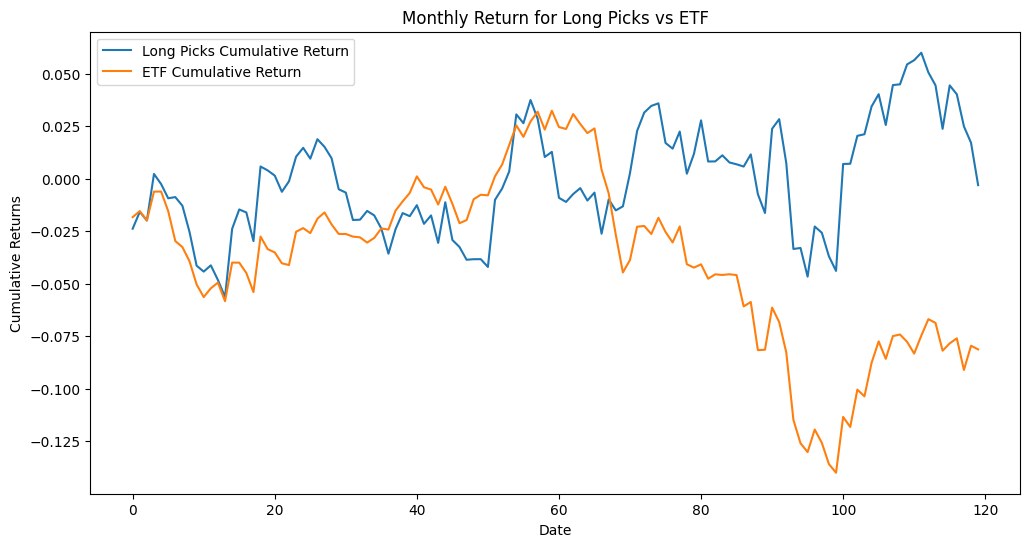

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(backtest_results['long_return'].cumsum(), label='Long Picks Cumulative Return')
plt.plot(backtest_results['etf_return'].cumsum(), label='ETF Cumulative Return')
plt.title('Monthly Return for Long Picks vs ETF')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()
